In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Does company size impact salary offered?
#### Do companies pay more for employees working outside the country?
#### Are remote workers more successful in certain countries?

## Loading and Cleaning data

In [2]:
df = pd.read_csv('ds_salaries.csv')

In [3]:
df.job_title.value_counts().head(10)

Data Scientist                143
Data Engineer                 132
Data Analyst                   97
Machine Learning Engineer      41
Research Scientist             16
Data Science Manager           12
Data Architect                 11
Big Data Engineer               8
Machine Learning Scientist      8
Principal Data Scientist        7
Name: job_title, dtype: int64

<AxesSubplot: >

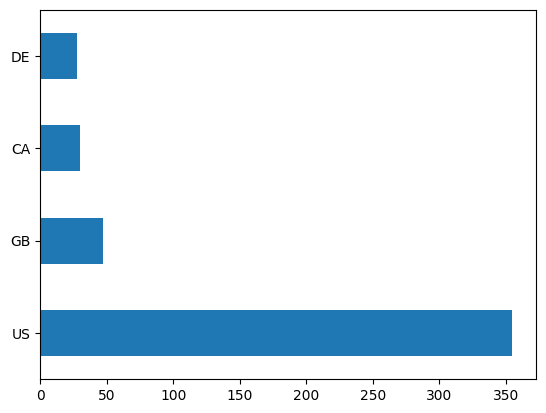

In [4]:
df.company_location.value_counts().head(4).plot.barh()

In [5]:
jobs = ['Data Scientist','Data Engineer','Data Analyst','Machine Learning Engineer']
df = df[df.job_title.isin(jobs)]

<AxesSubplot: >

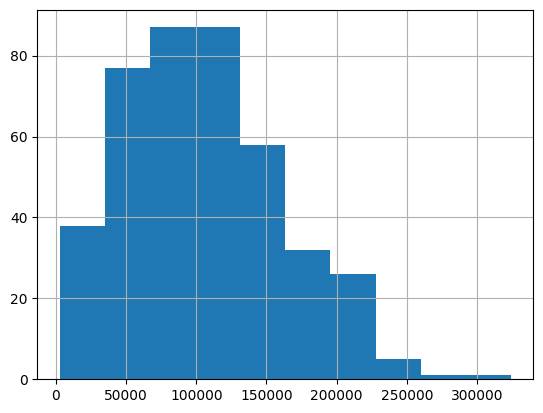

In [70]:
df.salary_in_usd.hist()

In [9]:
df.columns

Index(['Unnamed: 0', 'work_year', 'experience_level', 'employment_type',
       'job_title', 'salary', 'salary_currency', 'salary_in_usd',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size'],
      dtype='object')

In [7]:
#Selecting relevant columns
cols = ['experience_level','employment_type','salary_in_usd',
        'employee_residence','company_location','remote_ratio','company_size']
df = df[cols]

#filtering salary outliers
df = df[df.salary_in_usd < 350000]
df.head()

,experience_level,employment_type,salary_in_usd,employee_residence,company_location,remote_ratio,company_size
0,MI,FT,79833,DE,DE,0,L
4,SE,FT,150000,US,US,50,L
5,EN,FT,72000,US,US,100,L
7,MI,FT,35735,HU,HU,50,L
10,EN,FT,51321,FR,FR,0,S


## Feature Engineering

In [8]:
df['in_country'] = df.employee_residence == df.company_location

<AxesSubplot: ylabel='in_country'>

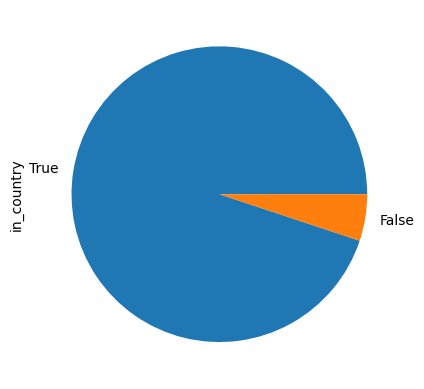

In [9]:
df.in_country.value_counts().plot.pie()

## Impact of Company Size

<AxesSubplot: ylabel='company_size'>

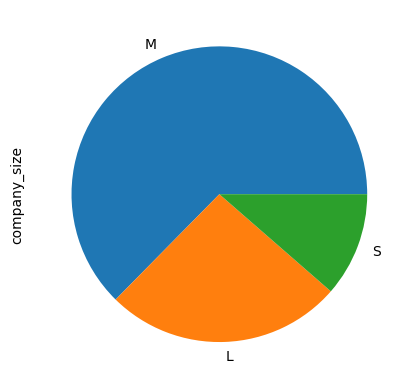

In [10]:
df.company_size.value_counts().plot.pie()

<AxesSubplot: ylabel='company_size'>

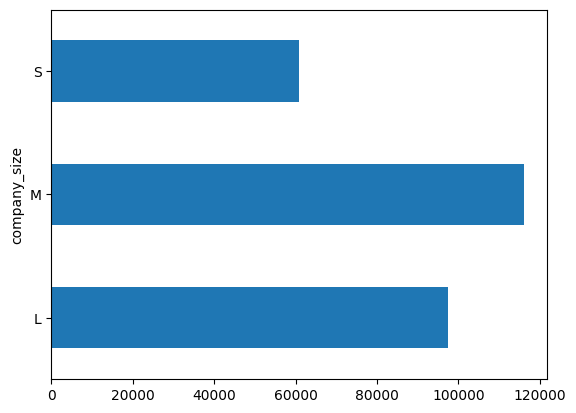

In [12]:
piv = df.groupby('company_size')
piv.salary_in_usd.mean().plot.barh()

### Expatriation Impact

In [14]:
#Creating a baseline dataframe of average incomes by company location and experience level
salary_df = df[df.in_country].groupby(['company_location','experience_level']).salary_in_usd.mean()

In [16]:
salary_df.head(5)

company_location  experience_level
AE                SE                  92500.0
AT                MI                  74130.0
                  SE                  91237.0
AU                EN                  86703.0
                  MI                  87425.0
Name: salary_in_usd, dtype: float64

In [18]:
#Joining the reference dataframe to the expatriate dataframe
ex_df = df[df.in_country == False].merge(salary_df, on=['company_location','experience_level'], how='left')

In [20]:
ex_df.dropna(subset=['salary_in_usd_y'], inplace=True)

In [22]:
ex_df['pay_ratio'] = ex_df.salary_in_usd_x / ex_df.salary_in_usd_y

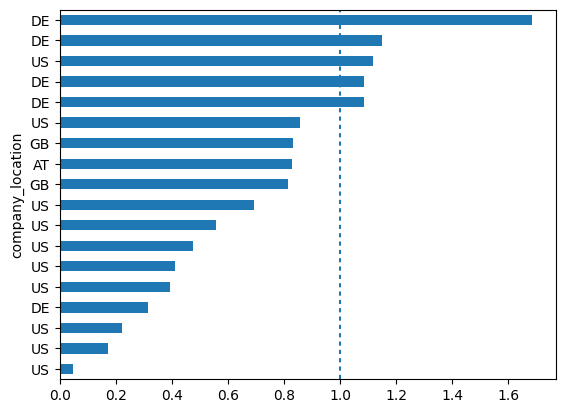

In [32]:
ex_df.index = ex_df.company_location
ex_df.sort_values(by=['pay_ratio']).pay_ratio.plot.barh()
plt.axvline(x=1,dashes=[2, 2])

### Remote Work

In [42]:
us_df = df[(df.company_location == 'US') & (df.employee_residence == 'US')]

In [47]:
us_df['remote'] = us_df.remote_ratio == 100

C:\Users\Toby\AppData\Local\Temp\ipykernel_15328\2124095261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_df['remote'] = us_df.remote_ratio == 100


<AxesSubplot: >

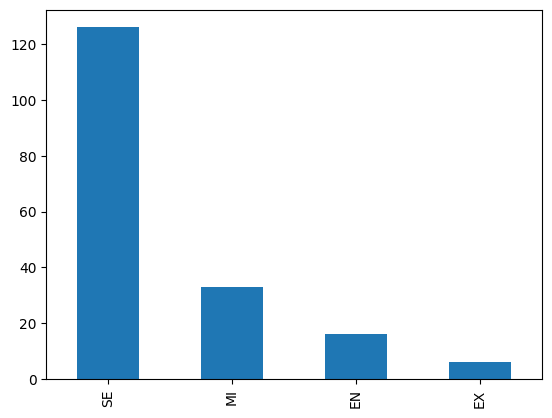

In [48]:
us_df[us_df.remote].experience_level.value_counts().plot.bar()

<AxesSubplot: >

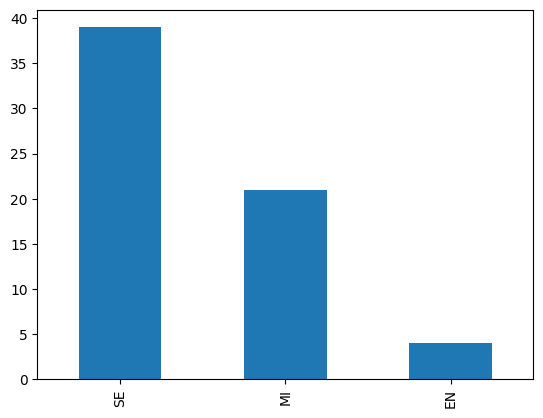

In [49]:
us_df[us_df.remote == False].experience_level.value_counts().plot.bar()

In [58]:
remote_piv = us_df[us_df.remote].groupby(['experience_level']).salary_in_usd.mean()
remote_piv = remote_piv.to_frame()
remote_piv.columns = ['remote_salary']
inperson_piv = us_df[us_df.remote == False].groupby(['experience_level']).salary_in_usd.mean()
inperson_piv = inperson_piv.to_frame()
inperson_piv.columns = ['local_salary']

In [64]:
res = pd.concat([remote_piv, inperson_piv], axis = 1)

<AxesSubplot: xlabel='experience_level'>

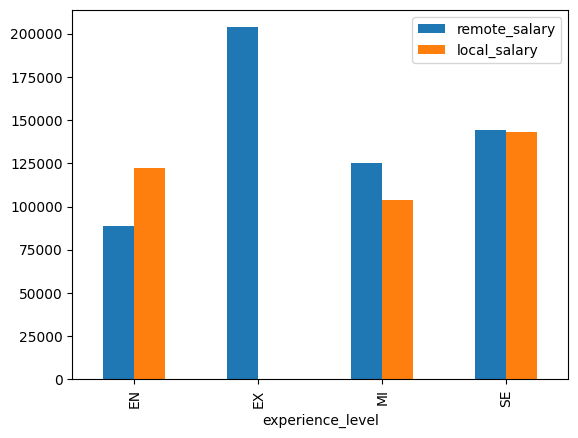

In [65]:
res.plot.bar()